## CRIS USAGE.

This jupyter notebook is amiming at checking step by step how to load an image, make a forward pass and perform inference with CRIS.

The high level script for training and testing looks as follows:
#### Training
```bash
python -u train.py --config config/refcoco/cris_r50.yaml \
    --opts TRAIN.input_size $input_size TRAIN.exp_name ${experiment_name} \
    TRAIN.batch_size 32 TRAIN.epochs 50 TRAIN.base_lr $base_lr TRAIN.batch_size_val 32
```
#### Testing 
```bash
# e.g., Evaluation on the val-set of the RefCOCO dataset
CUDA_VISIBLE_DEVICES=0 python -u test.py \
      --config config/refcoco/cris_r50.yaml \
      --opts TEST.test_split val-test \
             TEST.test_lmdb datasets/lmdb/refcocog_g/val.lmdb
```

In [1]:
import cv2
import torch
import os
import torch.nn.parallel
import torch.utils.data
import torch.nn.functional as F
from loguru import logger

import utils.config as config
from engine.engine import inference
from model import build_segmenter
from utils.dataset import RefDataset
cv2.setNumThreads(0)

/home/fabian/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fisr step is to load the config file.
cfg = config.load_cfg_from_cfg_file("config/refcoco/cris_r50.yaml")
# overriding the parameters passed in the script as --opts:
args = config.merge_cfg_from_list(cfg, ['TEST.test_split', 'val-test', 'TEST.test_lmdb', 'datasets/lmdb/refcoco/val.lmdb'])

In [3]:
args

CfgNode({'dataset': 'refcoco', 'train_lmdb': 'datasets/lmdb/refcoco/train.lmdb', 'train_split': 'train', 'val_lmdb': 'datasets/lmdb/refcoco/val.lmdb', 'val_split': 'val', 'mask_root': 'datasets/masks/refcoco', 'clip_pretrain': 'pretrain/RN50.pt', 'input_size': 416, 'word_len': 17, 'word_dim': 1024, 'vis_dim': 512, 'fpn_in': [512, 1024, 1024], 'fpn_out': [256, 512, 1024], 'gradient_acummulation_steps': 1, 'sync_bn': True, 'num_layers': 3, 'num_head': 8, 'dim_ffn': 2048, 'dropout': 0.1, 'intermediate': False, 'workers': 16, 'workers_val': 8, 'epochs': 50, 'milestones': [35], 'start_epoch': 0, 'batch_size': 32, 'batch_size_val': 32, 'base_lr': 0.0001, 'lr_decay': 0.1, 'lr_multi': 0.1, 'weight_decay': 0.0, 'max_norm': 0.0, 'manual_seed': 0, 'print_freq': 100, 'exp_name': 'CRIS_R50', 'output_folder': 'exp/refcoco', 'save_freq': 1, 'weight': None, 'resume': None, 'evaluate': True, 'dist_url': 'tcp://localhost:3681', 'dist_backend': 'nccl', 'multiprocessing_distributed': True, 'world_size': 1

## Create DataLoader Test Set RefCoco

I am deliberately setting batch size as 1, in order to visualize things more easily.
Different dataloaders will return different tuples. 
In this case we are taking the <font color="red">"test"</font> mode, so we will get the following outputs:

(image, params) 
where image is a normalized image and params is a dictionary containing:

        params = {
                'ori_img': non normalized image,
                'seg_id': seg_id,
                'mask_dir': mask_dir,
                'inverse': mat_inv,
                'ori_size': image_size,
                'sents': sents
            }


In [4]:
test_data = RefDataset(lmdb_dir=args.test_lmdb,
                           mask_dir=args.mask_root,
                           dataset=args.dataset,
                           split=args.test_split,
                           mode='test',
                           input_size=args.input_size,
                           word_length=args.word_len)
test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=1,
                                              pin_memory=True)

In [5]:
# parameters: dataset is refcoco

In [6]:
image, params = next(iter(test_loader))

/home/fabian/NTU_courseworks/ce6190_image/assignment1/CE6190/Assignment_1/CRIS/CRIS.pytorch/utils/dataset.py:130: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  self._init_db()
/home/fabian/NTU_courseworks/ce6190_image/assignment1/CE6190/Assignment_1/CRIS/CRIS.pytorch/utils/dataset.py:130: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  self._init_db()
/home/fabian/miniconda3/envs/robust_s3prl/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:44: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  data = [self.dataset[idx] for idx in possibly_batched_index]


In [7]:
args.test_lmdb

'datasets/lmdb/refcoco/val.lmdb'

The dataset is read using a lmdb library that I am not familiar with, but anyway, you can load a simple image by calling the following lines:

In [8]:
# I will first print the arguments here so you can see them... might make it easier to understand.
print(f'the "args.test_lmdb" argument: {args.test_lmdb}')
print(f'the "os.path.isdir(self.lmdb_dir)" just check if the directory is a folder or not: {os.path.isdir(args.test_lmdb)}')

the "args.test_lmdb" argument: datasets/lmdb/refcoco/val.lmdb
the "os.path.isdir(self.lmdb_dir)" just check if the directory is a folder or not: False


In [9]:
import lmdb
import pyarrow as pa

database_test_images = lmdb.open(args.test_lmdb,
                             subdir=os.path.isdir(args.test_lmdb),
                             readonly=True,
                             lock=False,
                             readahead=False,
                             meminit=False)

with database_test_images.begin(write=False) as txn:
    database_length = pa.deserialize((txn.get(b'__len__')))
    database_keys = pa.deserialize((txn.get(b'__keys__')))


/home/fabian/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  if await self.run_code(code, result, async_=asy):
/home/fabian/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  if await self.run_code(code, result, async_=asy):


Now we can start calling images from this database by just passing indexes to the keys, the keys are just numbers from 0 to 3811, with 3811 being
the size of the test set of refcoco (val-set to be precise).

In [10]:
index=0 #set any index to get the image you want.... use 0 if you want to compare with next(iter(test_loader)) call done before.
with database_test_images.begin(write=False) as txn:
    byteflow = txn.get(database_keys[index])
    ref = pa.deserialize(byteflow) # this will be a dictionary with many metadata.... 

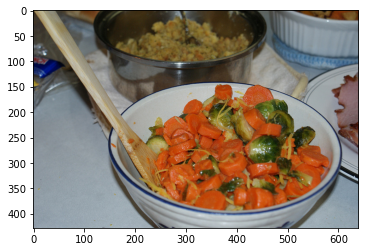

In [11]:
# get the image and process it...
import numpy as np
import matplotlib.pyplot as plt

ori_img = cv2.imdecode(np.frombuffer(ref['img'], np.uint8),
                       cv2.IMREAD_COLOR)
img_orig = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
img_size = img_orig.shape[:2]
plt.imshow(img_orig)
plt.show()

In [12]:
# you can verify from params when we read the whole dataset before , what is the text inputs for this image...
print(f'sents: { params["sents"]} ')
# if loading another image index is better to do:
sents = ref['sents']
sents

sents: [['bowl behind the others can only see part'], ['dish in top right corner'], ['white dish in the top right corner'], ['white pot upper right corner']] 


['bowl behind the others can only see part',
 'dish in top right corner',
 'white dish in the top right corner',
 'white pot upper right corner']

In [13]:
# we can obtain the mask by calling the seg_id key in params and the masking directory argument.
seg_id = ref['seg_id'] # only for image loaded with index 0 you could also do: params["seg_id"]
mask_dir = os.path.join(args.mask_root, str(seg_id) + '.png')
print(f"mask_dir, {mask_dir}")

mask_dir, datasets/masks/refcoco/77.png


There is more internal steps that actually happens, hence, for the sake of simplicity. It is better to proceed with the dataloader, considering we just want to learn how to take the image and get predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image processed inside dataloader has following size: (416, 416, 3)


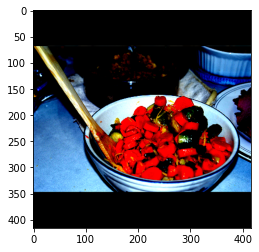

In [14]:
cpu_image_vor_plot = image[0].cpu().detach().numpy()
plt.imshow(np.rollaxis(cpu_image_vor_plot, 0, 3))
print(f"image processed inside dataloader has following size: {np.rollaxis(cpu_image_vor_plot, 0, 3).shape}")
plt.show() # this image is 416x416

In [31]:
# build the model.
from model import build_segmenter
model, param = build_segmenter(args)
model = torch.nn.DataParallel(model).cuda()
# load checkpoint.
output_dir = os.path.join(args.output_folder, args.exp_name)
checkpoint = torch.load(os.path.join(output_dir, "best_model.pth"))
model.load_state_dict(checkpoint['state_dict'], strict=True)

2022-10-20 16:32:00.000 | INFO     | model:build_segmenter:41 - Backbone with decay=325, Head=124


<All keys matched successfully>

In [33]:
# change model to evaluation mode.
model.eval()
# image to cuda...
img = image.cuda(non_blocking=True)
mask = cv2.imread(params['mask_dir'][0], flags=cv2.IMREAD_GRAYSCALE)
img.requires_grad=True

In [22]:
from utils.dataset import tokenize
iou_list = [] # to save predictions on each sentence
for sent in params['sents']:
    mask = mask / 255.
    text = tokenize(sent, args.word_len, True)
    text = text.cuda(non_blocking=True)
    # inference
    pred = model(img, text)
    print(pred.requires_grad)
    print(pred.shape)
    pred = torch.sigmoid(pred)
    print(f"size of the prediction is: {pred.shape}")
    print(f"size of the img is: {img.shape[-2:]}")
    if pred.shape[-2:] != img.shape[-2:]:
        pred = F.interpolate(pred,
                             size=img.shape[-2:],
                             mode='bicubic',
                             align_corners=True).squeeze()
    print(f"new size of the prediction is: {pred.shape}")
    # process one sentence
    h, w = params['ori_size'].numpy()[0]
    mat = params['inverse'].numpy()[0]
    pred = pred.cpu().numpy()
    pred = cv2.warpAffine(pred, mat, (w, h),
                          flags=cv2.INTER_CUBIC,
                          borderValue=0.)
    pred = np.array(pred > 0.35) # how is this threshold set?
    # iou
    inter = np.logical_and(pred, mask)
    union = np.logical_or(pred, mask)
    iou = np.sum(inter) / (np.sum(union) + 1e-6)
    iou_list.append(iou)

False
torch.Size([1, 1, 104, 104])
size of the prediction is: torch.Size([1, 1, 104, 104])
size of the img is: torch.Size([416, 416])
new size of the prediction is: torch.Size([416, 416])
False
torch.Size([1, 1, 104, 104])
size of the prediction is: torch.Size([1, 1, 104, 104])
size of the img is: torch.Size([416, 416])
new size of the prediction is: torch.Size([416, 416])
False
torch.Size([1, 1, 104, 104])
size of the prediction is: torch.Size([1, 1, 104, 104])
size of the img is: torch.Size([416, 416])
new size of the prediction is: torch.Size([416, 416])
False
torch.Size([1, 1, 104, 104])
size of the prediction is: torch.Size([1, 1, 104, 104])
size of the img is: torch.Size([416, 416])
new size of the prediction is: torch.Size([416, 416])


/home/fabian/miniconda3/envs/robust_s3prl/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


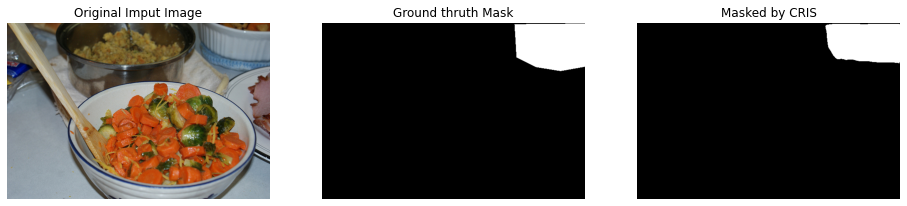

In [134]:
# select only masked area below
masked = mask.copy()
masked[mask == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(img_orig, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground thruth Mask", fontsize=12)

ax[2].imshow(pred, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Masked by CRIS", fontsize=12)

plt.show()

In [128]:
image.shape

torch.Size([1, 3, 416, 416])